In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Load the uploaded file to inspect its content
file_path = '/content/drive/MyDrive/Colab Notebooks/Info256 Project/Mid Term Report/Inter Annotator Agreement.xlsx'
data = pd.read_excel(file_path, None)  # Load all sheets

# Display sheet names and the first few rows of each sheet to understand its structure
{sheet_name: data[sheet_name].head() for sheet_name in data.keys()}

{'Sheet1':                 ID                                               title  \
 0  147a134c4acc8567                               Product Suppt Mgr IV   
 1  ac42ef1bff2803b6             Assistant Manager - Product Operations   
 2  b3b53f14facdbe6e                          Product Marketing Manager   
 3  bb1fad41bc685e51  Regulatory Science Product Characterization Ma...   
 4  bba78e6274a8aa72  3PL Product Growth Project Manager (Lawrencevi...   
 
                             company   \
 0                       Academy Bank   
 1                                Gap   
 2                            Enavate   
 3  JTI - Japan Tobacco International   
 4                     Rick Cargo LLC   
 
                                          description technology  
 0  "**Summary**\n\n\n\nBe a results-oriented lead...     Non-PM  
 1  **About the job**\n\n**About Gap**\n\nGap has ...     Non-PM  
 2  Enavate is the company that transforms busines...     Non-PM  
 3  At JTI we celebrat

In [4]:
# Extract relevant columns
df = data["Sheet1"][["title", "description", "technology"]].dropna()
print(f"Loaded dataset with {len(df)} rows")

# Preprocessing to encode the technology labels
titles = df["title"].tolist()
descriptions = df["description"].tolist()
labels = df["technology"].tolist()

# Map labels to numerical values
unique_labels = sorted(set(labels))
label_map = {label: i for i, label in enumerate(unique_labels)}
labels = [label_map[label] for label in labels]

# Print class distribution
print("\nClass Distribution:")
for label, idx in label_map.items():
    count = labels.count(idx)
    print(f"{label}: {count} samples")

Loaded dataset with 105 rows

Class Distribution:
AI / ML: 9 samples
API: 2 samples
Cloud: 3 samples
Data: 4 samples
Non-PM: 29 samples
Other type of PM: 34 samples
Payments: 10 samples
Platform: 12 samples
Trust & Safety: 2 samples


## Majority Baseline

### Results:
- **Training Accuracy: 32.38%**

In [5]:
label_counts = {}
for label, idx in label_map.items():
    count = labels.count(idx)
    label_counts[label] = count
    print(f"{label}: {count} samples")

# Calculate the proportion of the most common label
most_common_count = max(label_counts.values())
total_count = len(labels)
proportion_most_common = most_common_count / total_count

print(f"\nProportion of the most common label: {proportion_most_common:.4f}")

AI / ML: 9 samples
API: 2 samples
Cloud: 3 samples
Data: 4 samples
Non-PM: 29 samples
Other type of PM: 34 samples
Payments: 10 samples
Platform: 12 samples
Trust & Safety: 2 samples

Proportion of the most common label: 0.3238


## BERT-BASE Embedding Classifier with Logistic Regression

### Configuration:
- **BERT Settings**:
  - `batch_size = 1`
  - `max_length = 512` (maximum token length for each input)
  
- **Logistic Regression Settings**:
  - Regularization parameter: `C = 0.1` (to prevent overfitting)
  - Maximum iterations: `max_iter = 500` (to ensure convergence during training)

### Results:
- **Training Accuracy**: 100%
- **Validation Accuracy: 52.38%**


In [6]:
# Split the data into 80% train and 20% validation sets
X_train_BERT, X_val_BERT, y_train_BERT, y_val_BERT = train_test_split(
    list(zip(titles, descriptions)), labels,
    test_size=0.2,
    random_state=256,
    stratify=labels  # Ensure balanced split
)

# Unzip the training and validation data
train_titles, train_descriptions = zip(*X_train_BERT)
val_titles, val_descriptions = zip(*X_val_BERT)

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# Process all data at once (in one batch)
def get_bert_embeddings(titles, descriptions, batch_size=None):
    """Extract BERT embeddings for given titles and descriptions"""
    batch_size = batch_size or len(titles)
    embeddings = []

    for i in tqdm(range(0, len(titles), batch_size)):
        batch_titles = titles[i:i + batch_size]
        batch_descriptions = descriptions[i:i + batch_size]

        # Combine title and description
        texts = [f"{title} {desc}" for title, desc in zip(batch_titles, batch_descriptions)]

        # Tokenize
        encoded = tokenizer(texts,
                          padding=True,
                          truncation=True,
                          max_length=512,
                          return_tensors='pt')

        # Move to device
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        # Get embeddings
        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids,
                               attention_mask=attention_mask,
                               return_dict=True)

            # Use mean pooling instead of just CLS token
            mask = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            masked_embeddings = outputs.last_hidden_state * mask
            summed = torch.sum(masked_embeddings, 1)
            counts = torch.clamp(mask.sum(1), min=1e-9)
            mean_pooled = summed / counts
            batch_embeddings = mean_pooled.cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Extract embeddings for train and validation sets
print("\nExtracting BERT embeddings for training set...")
train_embeddings = get_bert_embeddings(train_titles, train_descriptions)
print("Extracting BERT embeddings for validation set...")
val_embeddings = get_bert_embeddings(val_titles, val_descriptions)

# Scale the embeddings for Logistic Regression
scaler = StandardScaler()
train_embeddings_scaled = scaler.fit_transform(train_embeddings)
val_embeddings_scaled = scaler.transform(val_embeddings)

# C = 0.1 to avoid overfitting, max_iter = 500 to speed up training
clf_BERT = LogisticRegression(C=0.1, max_iter=500, random_state=256)
clf_BERT.fit(train_embeddings_scaled, y_train_BERT)

train_score = clf_BERT.score(train_embeddings_scaled, y_train_BERT)
val_score = clf_BERT.score(val_embeddings_scaled, y_val_BERT)

print(f"  Train accuracy: {train_score:.4f}")
print(f"  Val accuracy: {val_score:.4f}")

# Print detailed evaluation
y_pred_BERT = clf_BERT.predict(val_embeddings_scaled)
print("\nClassification Report:")

# Get unique labels present in the validation set
present_labels = sorted(set(y_val_BERT))
label_names = [list(label_map.keys())[i] for i in present_labels]

print(classification_report(y_val_BERT, y_pred_BERT,
                          labels=present_labels,
                          target_names=label_names,
                          digits=3))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Extracting BERT embeddings for training set...


100%|██████████| 1/1 [01:55<00:00, 115.75s/it]


Extracting BERT embeddings for validation set...


100%|██████████| 1/1 [00:28<00:00, 28.09s/it]

  Train accuracy: 1.0000
  Val accuracy: 0.5238

Classification Report:
                  precision    recall  f1-score   support

         AI / ML      0.500     0.500     0.500         2
           Cloud      0.000     0.000     0.000         1
            Data      0.000     0.000     0.000         1
          Non-PM      1.000     0.667     0.800         6
Other type of PM      0.455     0.714     0.556         7
        Payments      0.500     0.500     0.500         2
        Platform      0.000     0.000     0.000         2

        accuracy                          0.524        21
       macro avg      0.351     0.340     0.337        21
    weighted avg      0.532     0.524     0.509        21




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


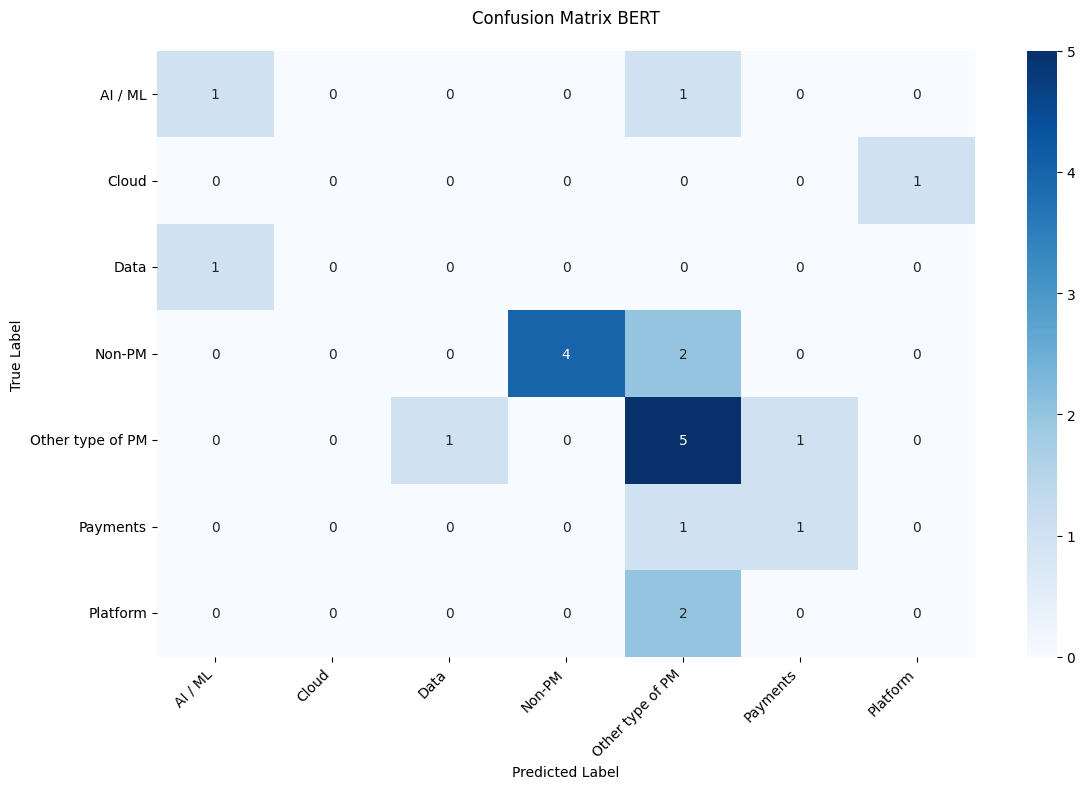

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_map, method = None, figsize=(12, 8)):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    title = f'Confusion Matrix {method}' if method else 'Confusion Matrix'

    # Get unique labels present in the data
    present_labels = sorted(set(y_true))
    label_names = [list(label_map.keys())[i] for i in present_labels]

    # Create figure and axes
    plt.figure(figsize=figsize)

    # Create heatmap
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)

    # Customize the plot
    plt.title(title, pad=20)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return plt

plot = plot_confusion_matrix(y_val_BERT, y_pred_BERT, label_map, method = 'BERT')
plt.show()

In [ ]:
def display_misclassifications(model_name, predictions, true_labels, texts, label_map, target_pred='Other type of PM',
                             target_true_labels=['AI / ML', 'Non-PM']):
    """
    Display misclassifications where model predicted target_pred but was actually one of target_true_labels

    Args:
        model_name: str, name of the model ('BERT' or 'TFIDF')
        predictions: array, model predictions
        true_labels: array, true labels
        texts: list, job titles + descriptions
        label_map: dict, mapping from label names to indices
        target_pred: str, target prediction label to analyze
        target_true_labels: list, target true labels to compare against
    """
    # Get label indices
    pred_idx = label_map[target_pred]
    true_indices = [label_map[label] for label in target_true_labels]

    print(f"\n=== {model_name} Model Misclassifications ===")

    # Find misclassifications for each target true label
    for true_label, true_idx in zip(target_true_labels, true_indices):
        misclassified = [(i, text) for i, (text, pred, true)
                        in enumerate(zip(texts, predictions, true_labels))
                        if pred == pred_idx and true == true_idx]

        if misclassified:
            i, text = misclassified[0]
            print(f"\nPredicted: {target_pred}")
            print(f"Actual: {true_label}")
            print("\nTitle + Description:")
            print(f"{text[:1000]}...")
            print("\n" + "-"*50)

### Sample Misclassfication ['Platform', 'Non-PM'] Predicted as Other type of PM

In [ ]:
# For BERT model
bert_val_texts = [f"{title} {desc}" for title, desc in zip(val_titles, val_descriptions)]
display_misclassifications(
    model_name='BERT',
    predictions=y_pred_BERT,
    true_labels=y_val_BERT,
    texts=bert_val_texts,
    label_map=label_map,
    target_true_labels=['Platform', 'Non-PM']
)


=== BERT Model Misclassifications ===

Predicted: Other type of PM
Actual: Platform

Title + Description:
Product operations controller (Hybrid, Reston, VA or Malvern, PA) Unlock Learning for All:

Here at Ellucian, we are motivated by a mission - power education so institutions can empower student success. We are the global market leader in EdTech for higher education, serving more than 2,900 customers and reaching over 22 million students in 50 countries. We are dedicated to helping higher education unlock learning for all by providing solutions that support the entire student lifecycle and deliver insights needed now and into the future.  

We embrace the power to **lead**, the courage to **innovate**, and the determination to **grow**. At our core, we believe in **humanizing** our approach, recognizing that our people are our greatest strength. With a shared vision of **transformation**, we endeavor to shape a brighter future for higher education.
About the Opportunity:

As the Pr

In [ ]:
def predict_technology_bert(title, description):
    """Predict technology category for a new job posting"""
    # Get embeddings
    embedding = get_bert_embeddings([title], [description])
    embedding_scaled = scaler.transform(embedding)

    # Get prediction
    prediction = clf_BERT.predict(embedding_scaled)[0]
    probabilities = clf_BERT.predict_proba(embedding_scaled)[0]

    # Get original label
    predicted_label = list(label_map.keys())[list(label_map.values()).index(prediction)]

    # Get confidence scores
    confidence_scores = {list(label_map.keys())[i]: prob
                        for i, prob in enumerate(probabilities)}

    return predicted_label, confidence_scores

## TF-IDF Classifier with Logistic Regression

### Configuration:
- **TF-IDF Vectorizer Settings**:
  - `max_features = 1000` (top 1000 features)
  - `ngram_range = (1, 2)` (unigrams and bigrams)
  - `stop_words = 'english'` (removes common English stop words)
  - `min_df = 2` (features must appear in at least 2 documents)
  - `max_df = 0.9` (features appear in at most 90% of documents)

- **Logistic Regression Settings**:
  - Regularization parameter: `C = 1` (default value)
  - Maximum iterations: `max_iter = 500` (for convergence)

### Results:
- **Training Accuracy**: 66.67%
- **Validation Accuracy: 42.86%**



In [7]:
# Combine title and description for TFIDF vectorizer
texts = [f"{title} {desc}" for title, desc in zip(titles, descriptions)]

# Train and validation sets split
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=256,
    stratify=labels  # Ensure balanced split
)

# Initialize and fit TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=768,  # Match BERT's dimension
    ngram_range=(1, 2), # unigrams and bigrams
    stop_words='english',
    min_df=2, # Appear in at least 2 documents
    max_df=0.9 # Appear in at most 90% of documents
)

# Texts to TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train_tfidf)
X_val_tfidf = tfidf.transform(X_val_tfidf)

# C = 1 default
print("\nTraining logistic regression classifier...")
clf = LogisticRegression(C=1, max_iter=500, random_state=256)
clf.fit(X_train_tfidf, y_train_tfidf)

# Print evaluation metrics
train_score = clf.score(X_train_tfidf, y_train_tfidf)
val_score = clf.score(X_val_tfidf, y_val_tfidf)
print(f"Train accuracy: {train_score:.4f}")

print(f"Validation accuracy: {val_score:.4f}")

# Print detailed evaluation
y_pred_tfidf = clf.predict(X_val_tfidf)
print("\nClassification Report:")

# Get unique labels present in the validation set
present_labels = sorted(set(y_val_tfidf))
label_names = [list(label_map.keys())[i] for i in present_labels]

print(classification_report(y_val_tfidf, y_pred_tfidf,
                          labels=present_labels,
                          target_names=label_names,
                          digits=3))

# Get top features for each class
def print_top_features(classifier, vectorizer, class_labels, n=10):
    """Print top features (words) for each class"""
    feature_names = np.array(vectorizer.get_feature_names_out())

    print("\nTop features per class:")
    for i, class_label in enumerate(class_labels):
        top_indices = np.argsort(classifier.coef_[i])[-n:]
        top_features = feature_names[top_indices]
        print(f"\n{class_label}:")
        print(", ".join(top_features))

print_top_features(clf, tfidf, list(label_map.keys()))

def predict_technology_tfidf(title, description):
    """Predict seniority level for a new job posting"""
    # Combine title and description
    text = f"{title} {description}"

    # Transform text using TF-IDF
    features = tfidf.transform([text])

    # Get prediction
    prediction = clf.predict(features)[0]
    probabilities = clf.predict_proba(features)[0]

    # Get original label
    predicted_label = list(label_map.keys())[list(label_map.values()).index(prediction)]

    # Get confidence scores
    confidence_scores = {list(label_map.keys())[i]: prob
                        for i, prob in enumerate(probabilities)}

    return predicted_label, confidence_scores


Training logistic regression classifier...
Train accuracy: 0.6667
Validation accuracy: 0.4286

Classification Report:
                  precision    recall  f1-score   support

         AI / ML      0.000     0.000     0.000         2
           Cloud      0.000     0.000     0.000         1
            Data      0.000     0.000     0.000         1
          Non-PM      0.600     0.500     0.545         6
Other type of PM      0.333     0.714     0.455         7
        Payments      1.000     0.500     0.667         2
        Platform      0.000     0.000     0.000         2

        accuracy                          0.429        21
       macro avg      0.276     0.245     0.238        21
    weighted avg      0.378     0.429     0.371        21


Top features per class:

AI / ML:
world, drive, seamless, experiences, users, platform, learning, app, ml, ai

API:
vision, business requirements, principles, develop, acceptance, military, benefits, agile, methodologies, familiarity

Clou

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


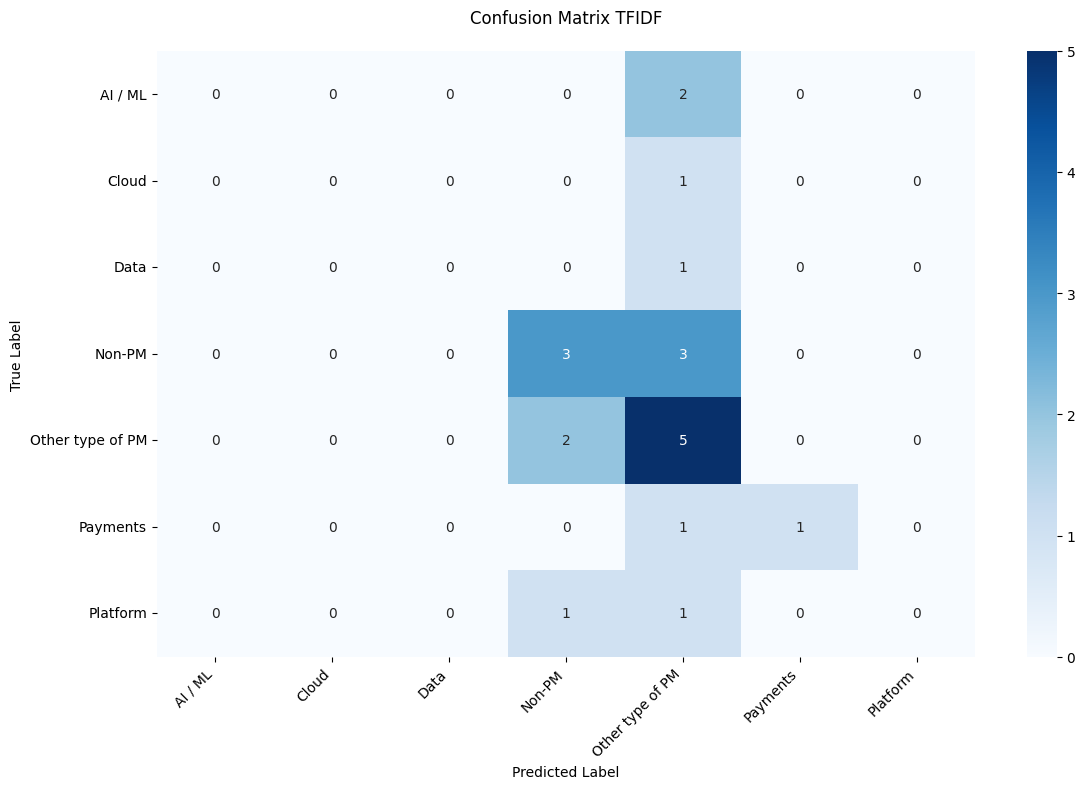

In [ ]:
plot = plot_confusion_matrix(y_val_tfidf, y_pred_tfidf, label_map, method = 'TFIDF')
plt.show()

### Sample Misclassfication ['AI / ML', 'Non-PM'] Predicted as Other type of PM

In [ ]:
# For TFIDF model
tfidf_val_texts = [texts[i] for i in range(len(texts)) if i in range(len(X_val_tfidf.toarray()))]
display_misclassifications(
    model_name='TFIDF',
    predictions=y_pred_tfidf,
    true_labels=y_val_tfidf,
    texts=tfidf_val_texts,
    label_map=label_map
)


=== TFIDF Model Misclassifications ===

Predicted: Other type of PM
Actual: AI / ML

Title + Description:
Senior Manager Product Operations - Marketplaces **Company Overview**
--------------------



ID.me is a high-growth enterprise software company that simplifies how people prove and share their identity online. The company empowers people to control their data through a portable and trusted login, which means they don't need to create a new password when visiting sites that have the ID.me button. ID.me's digital identity network has over 117 million registered members, and is used by fourteen federal agencies, agencies in 30 states and over 600 corporations for secure identity proofing and verification.



ID.me's technology meets the federal standards for consumer authentication set by the Commerce Department and is approved as a NIST 800-63-3 IAL2 / AAL2 credential service provider by the Kantara Initiative. In addition to helping people control their credentials and data, the c

## Sample Prediction
- [Google APM 2025 New Grad](https://www.google.com/about/careers/applications/jobs/results/124204114060944070-associate-product-manager-university-graduate-2025-start)


In [ ]:
title = "Associate Product Manager, University Graduate, 2025 Start"
description = """Minimum qualifications:
Currently enrolled in or graduated from a degree program within Product Management, Computer Science, Engineering, Data Science, Mathematics, Statistics, or a related technical field, or equivalent practical experience.
Internship or Teaching Assistant experience in Product Management software development or a similar technical field.
Experience leading entrepreneurial efforts or outreach within organizations while building cross-functional relationships.
Experience preparing and delivering technical presentations to an audience through internships, coursework, or extracurriculars.

Preferred qualifications:
Experience with methodologies aimed to drive product development and delivery.
Ability to start full-time by August 2025.
Ability to communicate in English fluently to support client relationship management in this region.
Excellent problem-solving, organizational, investigative, and critical thinking skills.
Excellent written and verbal communication skills.
Technical fluency including programming languages, data analysis, business case/modeling, pricing, design.
About the job
At Google, we put our users first. The world is always changing, so we need Product Managers who are continuously adapting and excited to work on products that affect millions of people every day.

In this role, you will work cross-functionally to guide products from conception to launch by connecting the technical and business worlds. You can break down complex problems into steps that drive product development.

One of the many reasons Google consistently brings innovative, world-changing products to market is because of the collaborative work we do in Product Management. Our team works closely with creative engineers, designers, marketers, etc. to help design and develop technologies that improve access to the world's information. We're responsible for guiding products throughout the execution cycle, focusing specifically on analyzing, positioning, packaging, promoting, and tailoring our solutions to our users.

Google aims to build products that organize the world's information and make it universally accessible to our users. As a Product Manager at Google, you could be working on new technologies, platforms, consumer facing products, and/or enterprise systems. The end goal will be to match you with the team that best aligns with your interests, experience, and where you will have the most impact.

The US base salary range for this full-time position is $102,000-$150,000 + bonus + equity + benefits. Our salary ranges are determined by role, level, and location. The range displayed on each job posting reflects the minimum and maximum target salaries for the position across all US locations. Within the range, individual pay is determined by work location and additional factors, including job-related skills, experience, and relevant education or training. Your recruiter can share more about the specific salary range for your preferred location during the hiring process.

Please note that the compensation details listed in US role postings reflect the base salary only, and do not include bonus, equity, or benefits. Learn more about benefits at Google.
Responsibilities
Understand markets and user requirements in depth.
Launch products and features, test their performance, and iterate quickly.
Work collaboratively with Engineering, Marketing, Legal, and UX on technologies.
Develop innovative solutions to problems by collaborating as needed across regions, product areas, and functions."""

predict_level_bert, confidence_scores_bert = predict_technology_bert(title, description)
print("\n")
print(f"Predicted technology by BERT: {predict_level_bert}")
print("Confidence scores BERT:")
for level, score in confidence_scores_bert.items():
    print(f"{level}: {score:.4f}")
print("\n")
predicted_level_tfidf, confidence_scores_tfidf = predict_technology_tfidf(title, description)
print(f"Predicted level by TF-IDF: {predicted_level_tfidf}")
print("Confidence scores TF-IDF:")
for level, score in confidence_scores_tfidf.items():
    print(f"{level}: {score:.4f}")


100%|██████████| 1/1 [00:00<00:00, 14.71it/s]



Predicted technology by BERT: Other type of PM
Confidence scores BERT:
AI / ML: 0.0067
API: 0.0540
Cloud: 0.0003
Data: 0.0035
Non-PM: 0.0041
Other type of PM: 0.8435
Payments: 0.0046
Platform: 0.0823
Trust & Safety: 0.0010


Predicted level by TF-IDF: Other type of PM
Confidence scores TF-IDF:
AI / ML: 0.0878
API: 0.0250
Cloud: 0.0233
Data: 0.0388
Non-PM: 0.2470
Other type of PM: 0.3034
Payments: 0.0873
Platform: 0.1636
Trust & Safety: 0.0238
